In [1]:
# ! pip install -qU duckduckgo-search langchain-community

In [2]:
from typing import Annotated
import os

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langchain_groq import ChatGroq
from langchain_community.vectorstores import FAISS
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
import re
import ast
from loguru import logger
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts.prompt import PromptTemplate
from dotenv import load_dotenv

load_dotenv()

os.environ['TAVILY_API_KEY'] = os.getenv("TAVILY_API_KEY")
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")

In [3]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

search.invoke("when is hidroelectrica founded??")

"Iberdrola was created on November 1, 1992, from the merger between Hidroeléctrica Española and Iberduero. [10] [11] Hidroeléctrica Española, also known as Hidrola, had started in 1907, while Iberduero arose from the merger between Hidroeléctrica Ibérica and Saltos del Duero in 1944.The origin of Iberdrola lies in the Spanish industrialisation in the early 20th century. About S.P.E.E.H. Hidroelectrica. S.P.E.E.H. Hidroelectrica S.A. generates and supplies green energy in Romania. The company operates 187 power plants with a hydroelectric capacity of 6.3 GW; and Crucea wind park with an installed capacity of 108 MW. The company was founded in 2000 and is based in Bucharest, Romania. The Three Gorges Dam in Central China is the world's largest power-producing facility of any kind.. Hydroelectricity, or hydroelectric power, is electricity generated from hydropower (water power). Hydropower supplies 15% of the world's electricity, almost 4,210 TWh in 2023, [1] which is more than all other 

In [4]:
from langchain_community.retrievers import TavilySearchAPIRetriever

retriever = TavilySearchAPIRetriever(k=2)

retriever.invoke("what is the current time in US?")

[Document(metadata={'title': 'Current local time in the United States - World clock', 'source': 'https://dateandtime.info/country.php?code=US', 'score': 0.7418428, 'images': []}, page_content='Current local time in the United States. What time is it in the USA right now? Time Format ▾ Time Format  UTC Current time by city Current time by country Time difference Current local time in the United States The United States is divided into 6 time zones. Full name: United States of America | Time Zone | Time | Cities in This Time Zone | | Eastern Time | Central Time | Mountain Time | Pacific Time | Alaska Time Find out the current time in all USA’s cities Daylight saving time (DST) in USA Most part of the United States observes daylight saving time. Daylight saving time in the USA is determined by state legislation. Current time in USA’s neighbouring countries'),
 Document(metadata={'title': 'Time in United States now - Time.is', 'source': 'https://time.is/United_States', 'score': 0.65887916,

In [5]:
def internet_searcher(query, k=2):
    """
    Function to perform a search using Tavily as the primary retriever,
    and falls back to DuckDuckGo if Tavily fails.
    
    Args:
    - query (str): The search query.
    - k (int): Number of results to retrieve with Tavily.

    Returns:
    - dict: Search results from Tavily or DuckDuckGo.
    """
    # Initialize Tavily and DuckDuckGo retrievers
    retriever = TavilySearchAPIRetriever(k=k)
    duck_search = DuckDuckGoSearchRun()

    try:
        # Attempt to use Tavily
        result = retriever.invoke(query)
        if result:
            return {"source": "Tavily", "results": result}
    except Exception as e:
        print(f"Tavily failed: {e}")

    try:
        # Fallback to DuckDuckGo
        result = duck_search.invoke(query)
        return {"source": "DuckDuckGo", "results": result}
    except Exception as e:
        print(f"DuckDuckGo failed: {e}")
        return {"source": None, "results": None}


In [6]:
# # Example usage
# if __name__ == "__main__":
#     query = "What is happening tomorrow?"
#     search_results = internet_searcher(query)
#     print(search_results)

{'source': 'Tavily', 'results': [Document(metadata={'title': "Events tomorrow. Find what's on tomorrow - FIXR", 'source': 'https://fixr.co/events/tomorrow', 'score': 0.54971373, 'images': []}, page_content="Events tomorrow. Find what's on tomorrow | FIXR Organise events Discover events Search events Sign In Events Tomorrow Looking for things to do tomorrow? Discover events happening tomorrow and book tickets. FILTERS Filters Filter results Hide sold out events Categories Search for Discover events today in FILTERS Placeholder time Placeholder Cityname Placeholder Placeholder time Placeholder Cityname Placeholder Placeholder time Placeholder Cityname Placeholder Placeholder time Placeholder Cityname Placeholder Placeholder time Placeholder Cityname Placeholder Placeholder time Placeholder Cityname Placeholder Placeholder time Placeholder Cityname Placeholder Placeholder time Placeholder Cityname Placeholder Placeholder time Placeholder Cityname Placeholder Placeholder time Placeholder C

In [7]:
llm = ChatGroq(model_name="llama-3.3-70b-versatile", temperature=0.5)

## Path Finder

In [8]:
def query_analyzer(user_query: str) -> str:
    template = """
   You are an intelligent decision-making engine for a chatbot application. Your task is to analyze the user's input and determine the appropriate method to generate a response. Based on the analysis, output a single integer value indicating which action to take next. 

    ### Inputs:
    1. **User Query:** `{user_query}`

    ### Decision Options:
    1. **Direct Answer:** Output `0` if the user query is a greeting or pleasantry.
    2. **Internet Search:** Output `1` if the user query can be answered using information available on the internet.
    3. **DB Search:** Output `2` if the user query is related to the Hidroelectrica company and requires accessing the vector database.

    ### Output Format:
    - A single integer value: `0`, `1`, or `2`.
    - Example: `0`

    ### Instructions:
    1. **Analyze the User Query** to determine which of the three decision options applies.
    2. **Ensure Exclusivity:** Only one option should be chosen, and the output must be either `0`, `1`, or `2`.
    3. **Output the Value** in the specified format based solely on the analysis.

    ### Examples:

    - **Greeting Query:**
    - **User Query:** "Hello! How are you?"
    - **Output:** `0`

    - **General Information Query:**
    - **User Query:** "What is the capital of France?"
    - **Output:** `1`

    - **Hidroelectrica Specific Query:**
    - **User Query:** "Can you provide the latest financial reports of Hidroelectrica?"
    - **Output:** `2`

    Generate the appropriate integer value based on the user's input below.  
    Only return the final integer value without other comments.  
    Remember, just the value alone.

    """
    question_prompt = PromptTemplate(input_variables=["user_query"], template=template)
    initiator_router = question_prompt | llm | StrOutputParser()
    output = initiator_router.invoke({"user_query":user_query})
    return output 

In [9]:
ans = query_analyzer(user_query="Hello there, how are you doing?")

In [10]:
ans

'0'

## AI Answer

In [11]:
def ai_answer(user_query: str, direct_answer:str,  internet_search:str, db_result:str) -> str:
    template = """
    You are a friendly and knowledgeable chatbot designed to assist users by providing accurate and helpful responses. Utilize the provided inputs to generate your answers as follows:

    ### Inputs:
    1. **User Query:** `{user_query}`
    2. **Direct Answer:** `{direct_answer}` *(Boolean: true or false)*
    3. **Internet Search Results:** `{internet_search}` *(List of dictionaries or None)*
    4. **Database Results:** `{db_result}` *(List of records or None)*

    ### Response Guidelines:
    - **Direct Answer is True:**
    - Respond directly to the user without referencing external data.
    - Example: For greetings or pleasantries, provide a friendly and appropriate reply.

    - **Direct Answer is False:**
    - **If Internet Search Results are Available:**
        - Use the internet search data to construct a comprehensive and accurate response.
        - Cite relevant information to support your answer.
    - **If Database Results are Available:**
        - Utilize the database records to provide detailed and specific information.
        - Reference the data to ensure the response is evidence-based.
    - **If Both are Available:**
        - Integrate information from both sources to enhance the quality and reliability of your answer.

    ### Additional Instructions:
    - Ensure the tone is friendly and approachable.
    - Provide clear and concise information.
    - If necessary, explain the sources of your information to build trust.
    - Do not include information beyond what is provided in the inputs.

    ### Example Structure:
    - **Greeting:**
    - "Hello! How can I assist you today?"

    - **Informational Response:**
    - "Based on the latest information I found [from the internet/database], here's what I can tell you about..."

    Generate your response below based on the guidelines above.
    
    """
    question_prompt = PromptTemplate(input_variables=["user_query", "direct_answer", "internet_search", "db_result"], template=template)
    initiator_router = question_prompt | llm | StrOutputParser()
    output = initiator_router.invoke({"user_query":user_query, "direct_answer":direct_answer, "internet_search":internet_search, "db_result":db_result})
    return output

## MultiQuery generator

In [12]:
def multiquery_generator(user_query: str) -> str:
    template = """
    You are an advanced language model designed to enhance user interactions by rephrasing queries and translating them into Romanian. Your task is to process a single user query by generating two distinct variations from different perspectives and then translating each variation into Romanian. The final output should be a list containing only the two translated Romanian queries.

    ### Input:
    - **Query:** `{user_query}`

    ### Instructions:
    1. **Generate Two Queries:**
    - **First Query:** Rephrase the original query from one perspective.
    - **Second Query:** Rephrase the original query from a different perspective.
    2. **Translate to Romanian:**
    - Translate both generated queries into Romanian.
    3. **Output:**
    - Provide a list of the two Romanian-translated queries only. Do not include any additional text or explanations.

    Only retun the final list without other comments.
    
    ### Example:
    - **Input Query:** "What are the health benefits of green tea?"
    - **Output:** ["Care sunt beneficiile pentru sănătate ale ceaiului verde?", "Cum influențează ceaiul verde sănătatea umană?"]

    Generate the list of two Romanian queries based on the input below.
    Return a LIST with the two queries in them.
    """
    question_prompt = PromptTemplate(input_variables=["user_query"], template=template)
    initiator_router = question_prompt | llm | StrOutputParser()
    output = initiator_router.invoke({"user_query":user_query})
    return output 

In [13]:
queries = multiquery_generator("What is the mission of Hidroelectrica?")

In [14]:
queries

'["Care este misiunea companiei Hidroelectrica?", "Ce obiective urmărește Hidroelectrica în activitatea sa?"]'

In [15]:
queries = ast.literal_eval(queries)
print(queries)

['Care este misiunea companiei Hidroelectrica?', 'Ce obiective urmărește Hidroelectrica în activitatea sa?']


## DB Searcher

In [16]:
logger.info("Loading Embedding model")
model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"} #can also be cpu
encode_kwargs = {"normalize_embeddings": True}
embeddings = HuggingFaceBgeEmbeddings(
            model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
        )

2024-12-30 00:57:07.434 | INFO     | __main__:<module>:1 - Loading Embedding model
C:\Users\timmy_3aupohg\AppData\Local\Temp\ipykernel_18272\4170509625.py:5: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceBgeEmbeddings(
c:\Users\timmy_3aupohg\anaconda3\envs\hidro_app\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# Loading the vector database
vec_db = FAISS.load_local("../faiss_index", embeddings, allow_dangerous_deserialization=True)

In [18]:
def remove_symbols(text):
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    return cleaned_text

In [19]:
def most_similar_document(query: list) -> list:
    all_docs = []
    query = list(set(query))
    for doc in query:
        retrieval = vec_db.as_retriever(search_type="mmr", search_kwargs={"k": 1, 'lambda_mult': 0.25})
        query_docs = retriever.invoke(doc)
        docs = [remove_symbols(i.page_content) for i in query_docs[:1]]
        all_docs.extend(docs)
    return all_docs

In [20]:
# Testing the function
db_result = most_similar_document(query=queries)
print(db_result)

['Hidroelectrica este lider in productia de energie electrica si principalul furnizor de servicii tehnologice necesare in Sistemul Energetic National  Misiunea noastra  Hidroelectrica  Energia care ne unește Urmărește clipul Hidroelectrica pe Youtube și pe rețelele sociale', 'Hidroelectrica urmărește să se numere printre producătorii de energie regenerabilă la nivel european care își desfășoară activitatea în condiţii de înaltă calitate tehnică şi siguranţă se mai arată în plan  și un ciclu nou de viață de 30 ani pentru centralele hidroelectrice ce vor fi retehnologizate Hidroelectrica']


In [21]:
def dbanswer_generator(user_query: str,  internet_search:str, db_result:str) -> str:
    template = """
    You are an answer generator tasked with providing the most accurate and contextually relevant answer to a user's query. You are provided with three inputs:
    1. **User Query (in English)**: `{user_query}` -  A question or request for information from the user.
    2. **Database Answer (in Romanian)**: `{db_result}` -  An answer retrieved from a database, which may be outdated or partially accurate.
    3. **Internet Answer (in English)**: `{internet_search}` -  Additional information retrieved from the internet, which is likely more up-to-date and accurate.

    Your task is to:
    1. Fully understand the user's query to determine the key details and requirements.
    2. Translate the Romanian database answer into English, ensuring it is clear and contextually related to the user query.
    3. Compare the translated database answer with the internet answer:
    - Prioritize the internet answer when it is more recent or accurate.
    - Use the database answer if it provides unique, relevant insights not present in the internet answer.
    - Cross-check both sources for consistency and accuracy.
    4. Generate a coherent, detailed, and accurate response to the user's query by synthesizing information from all sources.

    Ensure the final response:
    - Addresses the user's question directly and comprehensively.
    - Acknowledges any discrepancies between the sources when necessary.
    - Is clear, concise, and well-structured in English.

    ### Example Input and Process:
    - **User Query**: "What are the benefits of drinking green tea?"
    - **Database Answer (Romanian)**: "Ceaiul verde poate ajuta la pierderea în greutate și îmbunătățește sănătatea inimii."
    - **Internet Answer**: "Green tea is rich in antioxidants, may help with weight loss, improve heart health, and enhance brain function."

    ### Final Response:
    - Translate the Romanian answer to: "Green tea can help with weight loss and improves heart health."
    - Compare and synthesize: Include additional benefits like antioxidants and brain function from the internet source.
    - Deliver a final response: "Green tea is rich in antioxidants, may help with weight loss, improve heart health, and enhance brain function."

    Generate the final response to the user query in fluent, natural English.

    ### Instructions for Generating the Answer:
    Use these steps as a guide to ensure accuracy and relevance:
    1. Understand the query.
    2. Translate and interpret the Romanian answer.
    3. Cross-reference with internet data.
    4. Produce a final response that is user-centric and authoritative.
    
    Return the Final Response alone without other explanation. 
    ONLY the FINAL RESPONSE should be the output please.

    """
    question_prompt = PromptTemplate(input_variables=["user_query", "internet_search", "db_result"], template=template)
    initiator_router = question_prompt | llm | StrOutputParser()
    output = initiator_router.invoke({"user_query":user_query,  "internet_search":internet_search, "db_result":db_result})
    return output 

In [22]:
search_results= internet_searcher("What is the mission of Hidroelectrica a germany company?")

In [23]:
search_results

{'source': 'Tavily',
 'results': [Document(metadata={'title': 'Top 23 Hydropower Companies: Powering a Sustainable Future - Inven', 'source': 'https://www.inven.ai/company-lists/top-23-hydropower-companies', 'score': 0.5415791, 'images': []}, page_content='Hydropower companies harness the power of flowing or falling water to produce clean and renewable energy. GE is a renewable energy solutions company that offers a wide range of sustainable solutions for power generation. Iberdrola is a leading company in the renewable energy sector, specializing in offshore and onshore wind, photovoltaic, hydroelectric power, and smart grid solutions. Statkraft is a global renewable energy company that specializes in hydropower and solar development. Hidroelectrica is an energy company that specializes in the production and supply of electric power. Natel Energy is a renewable energy company that focuses on acquiring and upgrading existing hydropower assets, as well as developing new sustainable hydr

In [24]:
answer = dbanswer_generator(user_query="What is the mission of Hidroelectrica a germany company?", internet_search=search_results, db_result=db_result)

In [25]:
answer

"Hidroelectrica's mission is to be a leader in the production of electric energy and the main provider of technological services necessary for the National Power System. The company aims to consolidate its leading position in the Romanian energy market through the optimal development of its generation capacities. Hidroelectrica also strives to be among the top European renewable energy producers, operating with high technical quality and safety. Additionally, the company plans to extend the life cycle of its hydroelectric power plants by 30 years through re-technologization. As a key player in the energy sector, Hidroelectrica specializes in the production and supply of electric power, providing approximately 90% of the ancillary services needed for the operation of the National Power System."

In [26]:
print(answer)

Hidroelectrica's mission is to be a leader in the production of electric energy and the main provider of technological services necessary for the National Power System. The company aims to consolidate its leading position in the Romanian energy market through the optimal development of its generation capacities. Hidroelectrica also strives to be among the top European renewable energy producers, operating with high technical quality and safety. Additionally, the company plans to extend the life cycle of its hydroelectric power plants by 30 years through re-technologization. As a key player in the energy sector, Hidroelectrica specializes in the production and supply of electric power, providing approximately 90% of the ancillary services needed for the operation of the National Power System.


#### Wrapping the DB searchg answer in a function

In [27]:
def list_cleaner(input_data):
    """
    Clean input to ensure it is returned as a list.
    
    Args:
        input_data (str or list): Input data, either a list in string format or a direct list.
    
    Returns:
        list: The cleaned list.
    """
    if isinstance(input_data, list):
        # If the input is already a list, return it directly
        return input_data
    elif isinstance(input_data, str):
        try:
            # Attempt to parse the string as a Python literal
            parsed = ast.literal_eval(input_data)
            if isinstance(parsed, list):
                return parsed
            else:
                raise ValueError("Input string does not represent a list.")
        except (ValueError, SyntaxError) as e:
            raise ValueError(f"Invalid input: {input_data}. Error: {e}")
    else:
        raise TypeError("Input must be a list or a string representing a list.")

In [28]:
def user_db_answer(user_query: str) -> str:
    logger.info("translating the user question")
    queries = multiquery_generator(user_query=user_query)
    cleaned_queries = list_cleaner(queries)
    logger.info("Searching the vec DB")
    rag_docs = most_similar_document(cleaned_queries)
    logger.info("Searching the internet")
    internet_search = internet_searcher(user_query)
    logger.info('Sending all info to AI to get the answer')
    answer = dbanswer_generator(user_query=user_query, internet_search=internet_search, db_result=rag_docs)
    return answer

In [29]:
answer = user_db_answer("What is the mission of Hidroelectrica a germany company?")

2024-12-30 00:57:27.537 | INFO     | __main__:user_db_answer:2 - translating the user question
2024-12-30 00:57:28.077 | INFO     | __main__:user_db_answer:5 - Searching the vec DB
2024-12-30 00:57:33.919 | INFO     | __main__:user_db_answer:7 - Searching the internet
2024-12-30 00:57:36.954 | INFO     | __main__:user_db_answer:9 - Sending all info to AI to get the answer


In [30]:
answer

'Hidroelectrica is a Romanian energy company, not a German company. The mission of Hidroelectrica is to produce and supply electric power, with a focus on renewable energy sources, particularly hydropower. The company aims to consolidate its leading position in the Romanian energy market through the optimal development of its generation capacities. Hidroelectrica also provides approximately 90% of the ancillary services needed for the operation of the National Power System. Additionally, the company has started producing wind energy and has entered into the production of other renewable energy sources, making it a sustainable energy producer with minimal environmental impact.'

In [31]:
print(answer)

Hidroelectrica is a Romanian energy company, not a German company. The mission of Hidroelectrica is to produce and supply electric power, with a focus on renewable energy sources, particularly hydropower. The company aims to consolidate its leading position in the Romanian energy market through the optimal development of its generation capacities. Hidroelectrica also provides approximately 90% of the ancillary services needed for the operation of the National Power System. Additionally, the company has started producing wind energy and has entered into the production of other renewable energy sources, making it a sustainable energy producer with minimal environmental impact.


In [32]:
answer = user_db_answer("When was Hidroelectrica founded?")
print(answer)

2024-12-30 00:57:38.463 | INFO     | __main__:user_db_answer:2 - translating the user question
2024-12-30 00:57:39.534 | INFO     | __main__:user_db_answer:5 - Searching the vec DB
2024-12-30 00:57:45.222 | INFO     | __main__:user_db_answer:7 - Searching the internet
2024-12-30 00:57:48.142 | INFO     | __main__:user_db_answer:9 - Sending all info to AI to get the answer


Hidroelectrica was founded in 2000. This information is consistently reported across both the translated database answer and the internet answer. The database answer, originally in Romanian, mentions that Hidroelectrica was established in July 2000, as per the Government of Romania's decision. The internet answer, which appears to be more recent and possibly more accurate, also confirms the founding year as 2000. Additionally, the internet answer provides further details about Hidroelectrica being a leader in electric power production and a major supplier of technological services necessary for the National Energy System in Romania. It is also noted that Hidroelectrica is the largest electricity producer in Romania and is listed on the Bucharest Stock Exchange. Therefore, the founding year of Hidroelectrica is accurately determined as 2000, with both sources providing a consistent answer to the user's query.


### Internet Search answer

In [33]:
def internet_search_ai(user_query: str, internet_search:str) -> str:
    template = """
    You are a friendly and knowledgeable chatbot designed to assist users by providing accurate and helpful responses. Utilize the provided inputs to generate your answers as follows:

    ### Inputs:
        - User Query: {user_query}
        - Internet Search Results: {internet_search} (List of dictionaries or None)
        
    ### Response Guidelines:
    **If Internet Search Results are Available:**
        - Use the internet search data to construct a comprehensive and accurate response.
        - Cite relevant information to support your answer.
        
    **If No Internet Search Results:**
        - Provide a direct and informative answer based on your knowledge.
        
    ### Additional Instructions:
        - Ensure the tone is friendly and approachable.
        - Provide clear and concise information.
        - If necessary, explain the sources of your information to build trust.
        - Do not include information beyond what is provided in the inputs.
        
    ### Example Structure:
    **Greeting:**
    - "Hello! How can I assist you today?"
    **Informational Response**:
    - "Based on the latest information I found [from the internet], here's what I can tell you about..."
        
    Generate your response below in a conversational and informative manner based on the guidelines above.
    
    ### Instruction:
        - Only return the final answer as repsonse. 
        - Don't add extra explanations or something. 
        - Return the final answer always.
    
    """
    question_prompt = PromptTemplate(input_variables=["user_query", "internet_search"], template=template)
    initiator_router = question_prompt | llm | StrOutputParser()
    output = initiator_router.invoke({"user_query":user_query, "internet_search":internet_search})
    return output

In [34]:
def internet_answer(user_query: str) -> str:
    logger.info("Searching the internet")
    internet_search = internet_searcher(user_query)
    logger.info('Sending all info to AI to get the answer')
    answer = internet_search_ai(user_query=user_query, internet_search=internet_search)
    return answer

In [35]:
question = "what happened to opanai chatgpt yesterday?"
int_answer = internet_answer(user_query=question)

2024-12-30 00:57:49.892 | INFO     | __main__:internet_answer:2 - Searching the internet
2024-12-30 00:57:53.749 | INFO     | __main__:internet_answer:4 - Sending all info to AI to get the answer


In [36]:
print(int_answer)

Hello. Based on the latest information I found from Newsweek and Yahoo, it appears that OpenAI's ChatGPT experienced a significant outage yesterday, with over 15,000 reports of the service not working, and 92 percent of the issues were directly related to ChatGPT. The problem was caused by an "upstream provider" and affected not only ChatGPT but also the API and Sora. OpenAI confirmed that they were actively working on a fix, and by 11:16 P.M. EST, they had restored full service.


### Direct Answer

In [37]:
def direct_answer_ai(user_query: str) -> str:
    template = """
    You are a friendly and knowledgeable chatbot designed to assist users by providing accurate and helpful responses. Utilize the provided inputs to generate your answers as follows:

    ### Inputs:
        - User Query: {user_query}
        
    ### Response Guidelines:
    - Respond directly to the user's query in a friendly and conversational tone.
    - Provide clear and concise information tailored to the query.
    - If appropriate, add a touch of warmth or personalization to make the response engaging.
        
    ### Example Structure:
    **Greeting:**
    - "Hello! How can I assist you today?"
    **Informational Response**:
    - "Based on the latest information I found [from the internet], here's what I can tell you about..."
        
    Generate your response below in a conversational and informative manner based on the guidelines above.
    
    ### Instruction:
        - Only return the final answer as repsonse. 
        - Don't add extra explanations or something. 
        - Return the final answer always.
    
    """
    question_prompt = PromptTemplate(input_variables=["user_query"], template=template)
    initiator_router = question_prompt | llm | StrOutputParser()
    output = initiator_router.invoke({"user_query":user_query})
    return output

In [38]:
def direct_answer(user_query: str) -> str:
    logger.info('Generating direct answers')
    answer = direct_answer_ai(user_query=user_query)
    return answer

In [39]:
print(direct_answer("Hello"))

2024-12-30 00:57:54.629 | INFO     | __main__:direct_answer:2 - Generating direct answers


Hello! How can I assist you today?


In [40]:
def get_romania_time():
    """Get the current date and time in Romania."""
    from datetime import datetime
    from pytz import timezone
    
    romania_timezone = timezone('Europe/Bucharest')
    now = datetime.now(romania_timezone)
    return now.strftime('%Y-%m-%d %H:%M:%S')


get_romania_time()

'2024-12-30 01:57:55'

# Wrapping all together

In [41]:
def chatbot(user_query:str) -> str:
    logger.info("Analyzing user query")
    analysis = query_analyzer(user_query=user_query)
    option = int(analysis)
    answer = None
    if option == 0: 
        answer = direct_answer(user_query=user_query)
    elif option == 1: 
        answer = internet_answer(user_query=user_query)
    elif option == 2: 
        answer = user_db_answer(user_query=user_query)
    return answer

In [42]:
answer = chatbot("Hello")

2024-12-30 00:57:55.380 | INFO     | __main__:chatbot:2 - Analyzing user query
2024-12-30 00:57:55.803 | INFO     | __main__:direct_answer:2 - Generating direct answers


In [43]:
answer

'Hello! How can I assist you today?'

In [44]:
answer = chatbot("Recent news about chatgpt")

2024-12-30 00:57:57.062 | INFO     | __main__:chatbot:2 - Analyzing user query
2024-12-30 00:57:57.432 | INFO     | __main__:internet_answer:2 - Searching the internet
2024-12-30 00:58:00.321 | INFO     | __main__:internet_answer:4 - Sending all info to AI to get the answer


In [45]:
print(answer)

Hello. How can I assist you today? Based on the latest information I found from the internet, here's what I can tell you about recent news on ChatGPT. OpenAI has revealed its latest iteration of ChatGPT, GPT-4o, which is supposed to be faster and has increased text and voice capabilities, as reported by CBS News. Additionally, according to TechCrunch, OpenAI has introduced a new way to interact with ChatGPT called "Canvas," which allows users to generate writing or code and have the model edit it. They have also announced a "Santa Mode" voice for December and are rolling out Advanced Voice Mode (AVM), an audio feature that makes ChatGPT more natural to speak with, including five new voices. These updates aim to enhance the user experience and provide more features for ChatGPT users.


In [46]:
answer = chatbot("What are the core values of hidroelectrica?")

2024-12-30 00:58:01.646 | INFO     | __main__:chatbot:2 - Analyzing user query
2024-12-30 00:58:02.053 | INFO     | __main__:user_db_answer:2 - translating the user question
2024-12-30 00:58:02.875 | INFO     | __main__:user_db_answer:5 - Searching the vec DB
2024-12-30 00:58:09.082 | INFO     | __main__:user_db_answer:7 - Searching the internet
2024-12-30 00:58:12.082 | INFO     | __main__:user_db_answer:9 - Sending all info to AI to get the answer


In [47]:
print(answer)

The core values of Hidroelectrica include performance, integrity, creativity, team spirit, and social responsibility. These values are essential to the company's mission of providing sustainable and renewable energy through hydroelectric power. Hidroelectrica aims to optimize its operational costs, improve the functioning of its production capacities, and contribute to energy security and environmental protection. As the leading provider of hydroelectric power in Romania, Hidroelectrica strives to utilize the country's natural water resources to provide sustainable hydro energy. The company also plays a crucial role in providing approximately 90% of the ancillary services needed for the operation of the National Power System. By prioritizing its core values and objectives, Hidroelectrica seeks to consolidate its position in the Romanian energy market and promote sustainable development.


## Wrapping in Agentic workflow

In [48]:
from langchain_core.tools import tool

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [49]:
import json
from typing import List, Literal, Optional

import tiktoken
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.documents import Document
from langchain_core.embeddings import Embeddings
from langchain_core.messages import get_buffer_string
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode

In [50]:
recall_vector_store = InMemoryVectorStore(OpenAIEmbeddings())

In [51]:
import uuid


def get_user_id(config: RunnableConfig) -> str:
    user_id = config["configurable"].get("user_id")
    if user_id is None:
        raise ValueError("User ID needs to be provided to save a memory.")

    return user_id

In [52]:
@tool
def save_recall_memory(memory: str, config: RunnableConfig) -> str:
    """Save memory to vectorstore for later semantic retrieval."""
    user_id = get_user_id(config)
    document = Document(
        page_content=memory, id=str(uuid.uuid4()), metadata={"user_id": user_id}
    )
    recall_vector_store.add_documents([document])
    return memory


@tool
def search_recall_memories(query: str, config: RunnableConfig) -> List[str]:
    """Search for relevant memories."""
    user_id = get_user_id(config)

    def _filter_function(doc: Document) -> bool:
        return doc.metadata.get("user_id") == user_id

    documents = recall_vector_store.similarity_search(
        query, k=3, filter=_filter_function
    )
    return [document.page_content for document in documents]

@tool
def get_current_time() -> str:
    """
    This tool is used to get the current time of the user timezone.
    """
    time = get_romania_time()
    return time


@tool
def chatbot_response(user_query:str) -> str:
    """summary

    Args:
        user_query (str): This is the user question. Anything outside the time question. 

    Returns:
        str: Returns an answer for the user based on the asked questions. 
    """
    response = chatbot(user_query=user_query)
    return response    

In [53]:
class State(MessagesState):
    # add memories that will be retrieved based on the conversation context
    recall_memories: List[str]

In [54]:
# Define the prompt template for the agent
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant with advanced long-term memory"
            " capabilities. Powered by a stateless LLM, you must rely on"
            " external memory to store information between conversations."
            " Utilize the available memory tools to store and retrieve"
            " important details that will help you better attend to the user's"
            " needs and understand their context.\n\n"
            "Memory Usage Guidelines:\n"
            "1. Actively use memory tools (save_core_memory, save_recall_memory)"
            " to build a comprehensive understanding of the user.\n"
            "2. Make informed suppositions and extrapolations based on stored"
            " memories.\n"
            "3. Regularly reflect on past interactions to identify patterns and"
            " preferences.\n"
            "4. Update your mental model of the user with each new piece of"
            " information.\n"
            "5. Cross-reference new information with existing memories for"
            " consistency.\n"
            "6. Prioritize storing emotional context and personal values"
            " alongside facts.\n"
            "7. Use memory to anticipate needs and tailor responses to the"
            " user's style.\n"
            "8. Recognize and acknowledge changes in the user's situation or"
            " perspectives over time.\n"
            "9. Leverage memories to provide personalized examples and"
            " analogies.\n"
            "10. Recall past challenges or successes to inform current"
            " problem-solving.\n\n"
            "## Recall Memories\n"
            "Recall memories are contextually retrieved based on the current"
            " conversation:\n{recall_memories}\n\n"
            "## Instructions\n"
            "Engage with the user naturally, as a trusted colleague or friend."
            " There's no need to explicitly mention your memory capabilities."
            " Instead, seamlessly incorporate your understanding of the user"
            " into your responses. Be attentive to subtle cues and underlying"
            " emotions. Adapt your communication style to match the user's"
            " preferences and current emotional state. Use tools to persist"
            " information you want to retain in the next conversation. If you"
            " do call tools, all text preceding the tool call is an internal"
            " message. Respond AFTER calling the tool, once you have"
            " confirmation that the tool completed successfully.\n\n",
        ),
        ("placeholder", "{messages}"),
    ]
)

In [55]:
tools = [save_recall_memory, search_recall_memories, get_current_time, chatbot_response]

In [56]:
gpt_model = ChatOpenAI(model_name="gpt-4o")
llama_model = ChatGroq(model_name="llama-3.3-70b-versatile")
model_with_tools = gpt_model.bind_tools(tools)
llama_with_tools = llama_model.bind_tools(tools)

In [57]:
tokenizer = tiktoken.encoding_for_model("gpt-4o")


def agent(state: State) -> State:
    """Process the current state and generate a response using the LLM.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        schemas.State: The updated state with the agent's response.
    """
    bound = prompt | model_with_tools
    recall_str = (
        "<recall_memory>\n" + "\n".join(state["recall_memories"]) + "\n</recall_memory>"
    )
    prediction = bound.invoke(
        {
            "messages": state["messages"],
            "recall_memories": recall_str,
        }
    )
    return {
        "messages": [prediction],
    }


def load_memories(state: State, config: RunnableConfig) -> State:
    """Load memories for the current conversation.

    Args:
        state (schemas.State): The current state of the conversation.
        config (RunnableConfig): The runtime configuration for the agent.

    Returns:
        State: The updated state with loaded memories.
    """
    convo_str = get_buffer_string(state["messages"])
    convo_str = tokenizer.decode(tokenizer.encode(convo_str)[:2048])
    recall_memories = search_recall_memories.invoke(convo_str, config)
    return {
        "recall_memories": recall_memories,
    }


def route_tools(state: State):
    """Determine whether to use tools or end the conversation based on the last message.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        Literal["tools", "__end__"]: The next step in the graph.
    """
    msg = state["messages"][-1]
    if msg.tool_calls:
        return "tools"

    return END

In [58]:
# Create the graph and add nodes
builder = StateGraph(State)
builder.add_node(load_memories)
builder.add_node(agent)
builder.add_node("tools", ToolNode(tools))

# Add edges to the graph
builder.add_edge(START, "load_memories")
builder.add_edge("load_memories", "agent")
builder.add_conditional_edges("agent", route_tools, ["tools", END])
builder.add_edge("tools", "agent")

# Compile the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

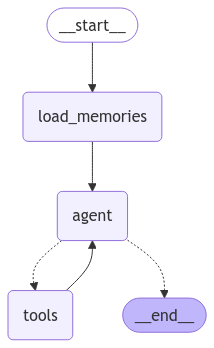

In [59]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [71]:
def pretty_print_stream_chunk(chunk):
    response = []
    for node, updates in chunk.items():
        print(f"Update from node: {node}")
        if "messages" in updates:
            updates["messages"][-1].pretty_print()
            response.append(updates["messages"][-1])
        else:
            print(updates)

        print("\n")
        
    return response

In [75]:
# NOTE: we're specifying `user_id` to save memories for a given user
config = {"configurable": {"user_id": "1", "thread_id": "1"}}

for chunk in graph.stream({"messages": [("user", "Hmmm, okay")]}, config=config):
    answer = pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ["The user's name is John."]}


Update from node: agent
================================== Ai Message ==================================

If you have any more questions or need further information, feel free to ask. I'm here to help!




In [77]:
answer[-1].content

"If you have any more questions or need further information, feel free to ask. I'm here to help!"

In [62]:
# NOTE: we're specifying `user_id` to save memories for a given user
config = {"configurable": {"user_id": "1", "thread_id": "1"}}

for chunk in graph.stream({"messages": [("user", "What is the time?")]}, config=config):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  get_current_time (call_Bu8b39plJJ39LYD2qi1Zy1Zi)
 Call ID: call_Bu8b39plJJ39LYD2qi1Zy1Zi
  Args:


Update from node: tools
================================= Tool Message =================================
Name: get_current_time

2024-12-30 02:03:53


Update from node: agent
================================== Ai Message ==================================

The current time is 2:03 AM on December 30, 2024.




In [63]:
# NOTE: we're specifying `user_id` to save memories for a given user
config = {"configurable": {"user_id": "1", "thread_id": "1"}}

for chunk in graph.stream({"messages": [("user", "Hello, once again")]}, config=config):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================

Hello, John! How can I assist you today?




In [64]:
# NOTE: we're specifying `user_id` to save memories for a given user
config = {"configurable": {"user_id": "1", "thread_id": "1"}}

for chunk in graph.stream({"messages": [("user", "What are the core values of hidroelectrica?")]}, config=config):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  search_recall_memories (call_rNbY88SEqJkw50fxR8iBfey3)
 Call ID: call_rNbY88SEqJkw50fxR8iBfey3
  Args:
    query: core values of Hidroelectrica


Update from node: tools
================================= Tool Message =================================
Name: search_recall_memories

[]




2024-12-30 01:05:10.084 | INFO     | __main__:chatbot:2 - Analyzing user query


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  chatbot_response (call_kyAfhhc5U68onpwtGSzmmq7g)
 Call ID: call_kyAfhhc5U68onpwtGSzmmq7g
  Args:
    user_query: What are the core values of Hidroelectrica?




2024-12-30 01:05:10.825 | INFO     | __main__:user_db_answer:2 - translating the user question
2024-12-30 01:05:11.341 | INFO     | __main__:user_db_answer:5 - Searching the vec DB
2024-12-30 01:05:18.467 | INFO     | __main__:user_db_answer:7 - Searching the internet
2024-12-30 01:05:21.423 | INFO     | __main__:user_db_answer:9 - Sending all info to AI to get the answer


Update from node: tools
================================= Tool Message =================================
Name: chatbot_response

The core values of Hidroelectrica include performance, integrity, creativity, team spirit, and social responsibility. These values are essential to the company's mission and objectives, which focus on optimizing its cost base and operational efficiency, as well as maximizing the utilization of its production capacities. As the leading provider of hydroelectric power in Romania, Hidroelectrica strives to contribute to the country's energy security and environmental protection through sustainable and renewable energy production. While the company's primary goal is to increase its value through strategic objectives, its core values underscore its commitment to ethical business practices, innovation, and community responsibility.


Update from node: agent
================================== Ai Message ==================================

Hidroelectrica's core value